In [ ]:
import os
import glob

from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter

In [ ]:
from langchain_experimental.text_splitter import SemanticChunker

In [ ]:
folder_path = "../data"
all_entries = os.listdir(folder_path)

# To get only files, filter the list
nama_files = [entry for entry in all_entries if os.path.isfile(os.path.join(folder_path, entry))]

documents = []
for doc in nama_files:
    doc = f"../data/{doc}"
    with open(doc, 'r', encoding='utf-8') as file:
        content = file.read()
    # doc.metadata["doc_name"] = doc
    documents.append(content)

In [ ]:
folder_path = "../data"
all_entries = os.listdir(folder_path)

# To get only files, filter the list
nama_files = [entry for entry in all_entries if os.path.isfile(os.path.join(folder_path, entry))]

documents = []

for file_path in nama_files:
    file_path = f"../data/{file_path}" 

    try:
        # Instantiate the TextLoader
        loader = TextLoader(file_path)

        # Load the documents
        document = loader.load()

        for doc in document:
            documents.append(doc)

    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
documents

In [ ]:
documents[0].metadata['tentang'] = "TENTANG PENYELENGGARA SISTEM ELEKTRONIK LINGKUP PRIVAT"
documents[1].metadata['tentang'] = "TENTANG GGARAAN SISTEM DAN TRANSAKSI ELEKTRONIK"
documents[2].metadata['tentang'] = "TENTANG PERDAGANGAN MELALUI SISTEM ELEKTRONIK"
documents[3].metadata['tentang'] = "TENTANG INFORMASI DAN TRANSAKSI ELEKTRONIK"
documents[4].metadata['tentang'] = "PERUBAHAN ATAS UNDANG-UNDANG NOMOR I1 TAHUN 2OO8 TENTANG INFORMASI DAN TRANSAKSI ELEKTRONIK"
documents[5].metadata['tentang'] = "PERUBAHAN KEDUA ATAS UNDANG-UNDANG NOMOR I1 TAHUN 2OO8 TENTANG INFORMASI DAN TRANSAKSI ELEKTRONIK"
documents[6].metadata['tentang'] = "TENTANG PELINDUNGAN DATA PRIBADI"
documents[7].metadata['tentang'] = "TENTANG HAK CIPTA"


In [ ]:
text = documents[0].page_content

In [ ]:
# !pip install langchain-core pandas

import os
import re
import pandas as pd
from typing import List, Dict
from langchain_core.documents import Document

# Set path folder data lu (sesuaikan kalau beda folder)
DATA_FOLDER = "../data"

In [ ]:
# Config: Mapping nama file ke Metadata (Judul & Topik)
LAW_CONFIG = {
    "Nomor_5_Tahun_2020.pdf.txt": {
        "name": "Permenkominfo No 5 Tahun 2020",
        "tentang": "Penyelenggara Sistem Elektronik Lingkup Privat"
    },
    "PP_Nomor_71_Tahun_2019.pdf.txt": {
        "name": "PP No 71 Tahun 2019",
        "tentang": "Penyelenggaraan Sistem dan Transaksi Elektronik (PSTE)"
    },
    "PP_Nomor_80_Tahun_2019.pdf.txt": {
        "name": "PP No 80 Tahun 2019",
        "tentang": "Perdagangan Melalui Sistem Elektronik (PMSE)"
    },
    "UU_Nomor_1_Tahun_2024.pdf.txt": {
        "name": "UU No 1 Tahun 2024",
        "tentang": "Perubahan Kedua Atas UU ITE (Informasi & Transaksi Elektronik)"
    },
    "UU_Nomor_11_Tahun_2008.pdf.txt": {
        "name": "UU No 11 Tahun 2008",
        "tentang": "Informasi dan Transaksi Elektronik (UU ITE Original)"
    },
    "UU_Nomor_19_Tahun_2016.pdf.txt": {
        "name": "UU No 19 Tahun 2016",
        "tentang": "Perubahan Pertama Atas UU ITE"
    },
    "UU_Nomor_27_Tahun_2022.pdf.txt": {
        "name": "UU No 27 Tahun 2022",
        "tentang": "Pelindungan Data Pribadi (PDP)"
    },
    "UU_Nomor_28_Tahun_2014.pdf.txt": {
        "name": "UU No 28 Tahun 2014",
        "tentang": "Hak Cipta"
    }
}

In [ ]:
class IndonesianLegalSplitter:
    def __init__(self, doc_name: str, doc_tentang: str):
        self.doc_name = doc_name
        self.doc_tentang = doc_tentang

    def clean_noise(self, text: str) -> str:
        # Bersihin header halaman, footer url, dll
        text = re.sub(r'--- HALAMAN \d+ ---', '', text)
        text = re.sub(r'\n\s*-\d+-\s*\n', '\n', text)
        text = re.sub(r'www\.peraturan\.go\.id', '', text)
        text = re.sub(r'\d+, No\.\d+', '', text) 
        text = re.sub(r'\n\s*\n', '\n', text)
        return text

    def split_text(self, raw_text: str) -> List[Document]:
        clean_content = self.clean_noise(raw_text)
        lines = clean_content.split('\n')
        chunks = []
        
        # State Variables
        current_bab = "Pembukaan"
        current_pasal_title = "Umum"
        current_pasal_num = 0 # Counter buat tracking urutan pasal
        buffer_text = []
        
        # Regex (Start of Line only)
        bab_pattern = re.compile(r'^\s*(BAB\s+[IVXLCDM]+)', re.IGNORECASE)
        pasal_pattern = re.compile(r'^\s*(Pasal\s+(\d+))', re.IGNORECASE)

        for line in lines:
            line = line.strip()
            if not line: continue

            # 1. Deteksi BAB
            match_bab = bab_pattern.match(line)
            if match_bab:
                current_bab = match_bab.group(1).upper()
                buffer_text.append(line)
                continue

            # 2. Deteksi Pasal (Pake Logic Urutan N+1)
            match_pasal = pasal_pattern.match(line)
            if match_pasal:
                found_full_title = match_pasal.group(1)
                found_num = int(match_pasal.group(2))
                
                # Logic: Hanya anggap pasal baru JIKA urut (angka sekarang + 1)
                if found_num == current_pasal_num + 1:
                    # Save pasal sebelumnya ke list chunks
                    if buffer_text:
                        full_content = "\n".join(buffer_text)
                        if len(full_content) > 20: 
                            # Context Injection: Masukin Judul UU ke dalam teks chunk
                            header = f"{self.doc_name} ({self.doc_tentang})"
                            content_display = f"{header}\n{current_bab} > {current_pasal_title}:\n{full_content}"
                            
                            chunks.append(Document(
                                page_content=content_display,
                                metadata={
                                    "source": self.doc_name,
                                    "tentang": self.doc_tentang,
                                    "bab": current_bab,
                                    "pasal": current_pasal_title,
                                    "pasal_num": current_pasal_num
                                }
                            ))
                    
                    # Reset state untuk pasal baru ini
                    current_pasal_title = found_full_title.title()
                    current_pasal_num = found_num
                    buffer_text = [line]
                else:
                    # Kalau gak urut (misal di bagian Mengingat), anggap teks biasa
                    buffer_text.append(line)
            else:
                # Konten biasa
                buffer_text.append(line)

        # Flush sisa buffer terakhir
        if buffer_text:
            full_content = "\n".join(buffer_text)
            header = f"{self.doc_name} ({self.doc_tentang})"
            chunks.append(Document(
                page_content=f"{header}\n{current_bab} > {current_pasal_title}:\n{full_content}",
                metadata={
                    "source": self.doc_name,
                    "tentang": self.doc_tentang,
                    "bab": current_bab,
                    "pasal": current_pasal_title
                }
            ))

        return chunks

In [ ]:
def load_documents(folder_path):
    all_documents = []
    
    # Cek file yang ada di folder
    if not os.path.exists(folder_path):
        print(f"Error: Folder '{folder_path}' tidak ditemukan.")
        return []

    files = [f for f in os.listdir(folder_path) if f.endswith(".txt")]
    print(f"🔍 Ditemukan {len(files)} file .txt di folder '{folder_path}'\n")

    for filename in files:
        if filename in LAW_CONFIG:
            config = LAW_CONFIG[filename]
            file_path = os.path.join(folder_path, filename)
            
            print(f"🚀 Processing: {config['name']}...")
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    raw_text = f.read()
                
                splitter = IndonesianLegalSplitter(
                    doc_name=config['name'],
                    doc_tentang=config['tentang']
                )
                
                file_chunks = splitter.split_text(raw_text)
                all_documents.extend(file_chunks)
                print(f"   ✅ OK. Generated {len(file_chunks)} chunks.")
                
            except Exception as e:
                print(f"   ❌ ERROR: {e}")
        else:
            print(f"⚠️  Skipping: {filename} (Tidak terdaftar di Config)")
            
    return all_documents

In [ ]:
# Eksekusi Loading
final_docs = load_documents(DATA_FOLDER)

print("\n" + "="*40)
print(f"🎉 TOTAL CHUNKS: {len(final_docs)}")
print("="*40)

In [ ]:
final_docs[200] 

In [ ]:
for doc in final_docs:
    print(doc.metadata)

In [3]:
from 
from dotenv import load_dotenv
import os

load_dotenv(override=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

NameError: name 'OpenAIEmbeddings' is not defined

In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv(override=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="../database",  # Where to save data locally, remove if not necessary
)

retriever = vector_store.as_retriever()

d:\LLM_PROJECT\LegalChatBot\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
vector_store.add_documents(final_docs)

In [ ]:
retriever = vector_store.as_retriever(
    search_kwargs={'filter': {"pasal_num": 2}}
)

In [ ]:
retriever = vector_store.as_retriever()

In [ ]:
retriever.invoke("hukuman")

In [ ]:
from dotenv import load_dotenv
import os
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

load_dotenv(override=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
llm = init_chat_model("gpt-4o-mini", temperature=0)

In [ ]:
def rag_linear(question: str):
    data = retriever.invoke(question)
    message = f"""
Jawab pertanyaan user berdasarkan dokumen yang tersedia dan berikan sumber Pasal dan UU nya

Pertanyaan:
{question}

Dokumen:
{data}
"""
    chat = llm.invoke(message)
    return chat

In [ ]:
jawaban = rag_linear("apa yang harus dilakukan sebelum membuat saas")

In [ ]:
retriever.invoke("apa yang harus dilakukan sebelum membuat saas")

In [ ]:
print(jawaban.content)

----
# Langchain
----

In [15]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

# --- A. DEFINISI STATE (Memory Agent) ---
# Ini struktur data yang bakal dioper-oper antar Node
class AgentState(TypedDict):
    # 'add_messages' otomatis nambahin chat history, gak cuma nimpain
    messages: Annotated[list[BaseMessage], add_messages]

# --- B. DEFINISI TOOLS (Senjata Agent) ---
# Pastikan 'vector_store' lu udah ready di scope ini ya Tang!

@tool
def cari_pasal_spesifik(nomor_pasal: int, tentang_pasal: str):
    """
    Gunakan tool ini HANYA jika user bertanya tentang NOMOR PASAL yang spesifik.
    Input: 
    nomor_pasal : Angka integer (contoh: 5, 27),
    tentang_pasal : Pasal tentang apa (contoh: Hak Cipta)
    """
    print(f"   🕵️ [TOOL] Filtering Pasal {nomor_pasal} tentang {tentang_pasal}")
    # Implementasi filter kayak yang kita bahas sebelumnya
    retriever = vector_store.as_retriever(
        search_kwargs={"k": 3, "filter": {"pasal_num": nomor_pasal}}
    )
    docs = retriever.invoke(f"Isi pasal {tentang_pasal}")
    return "\n\n".join([d.page_content for d in docs]) if docs else "Pasal tidak ditemukan."

@tool
def cari_prosedur_hukum(query: str):
    """
    Gunakan tool ini untuk mencari prosedur, sanksi, atau definisi umum
    tanpa nomor pasal spesifik. Contoh: "Cara daftar PSE", "Sanksi denda".
    """
    print(f"   📚 [TOOL] Semantic Search: '{query}'")
    retriever = vector_store.as_retriever(search_kwargs={"k": 4})
    docs = retriever.invoke(query)
    return "\n\n".join([d.page_content for d in docs])

# List tools yang akan di-bind ke LLM
tools = [cari_pasal_spesifik, cari_prosedur_hukum]

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# --- D. NODE FUNCTION ---

def agent_node(state: AgentState):
    """
    Ini otak utamanya. Dia baca history pesan, terus nentuin mau ngapain.
    """
    messages = state["messages"]
    
    # SYSTEM PROMPT (Kunci Persona "Konsultan Legal Software")
    system_prompt = (
        "Lu adalah 'LegalTech Assistant', konsultan hukum spesialis software development di Indonesia. "
        "Tugas lu memastikan software user patuh pada regulasi seperti Permenkominfo No 5/2020 (PSE), "
        "UU ITE, UU Hak Cipta, dan UU PDP.\n\n"
        "RULES:\n"
        "1. Jawab HANYA berdasarkan konteks yang diberikan tools. Jangan ngarang hukum.\n"
        "2. Gunakan gaya bahasa profesional tapi santai (seperti senior engineer ke junior).\n"
        "3. Selalu sebutkan dasar hukumnya (misal: 'Sesuai Pasal X...').\n"
        "4. Jika user bertanya teknis coding, tolak dengan halus, fokus ke aspek legalnya."
    )
    
    # Gabungin system prompt + chat history
    if isinstance(messages[0], HumanMessage):
         messages = [HumanMessage(content=system_prompt)] + messages
    else:
         # Kalau message pertama udah system, biarin. Kalau belum, inject.
         # (Simplifikasi: Kita taruh system instruction di invoke awal atau di sini)
         pass 

    # Panggil LLM
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# --- E. CONDITIONAL LOGIC (Router) ---

In [24]:
# --- TAMBAHAN IMPORT ---
from langgraph.checkpoint.memory import MemorySaver # <--- INI KUNCINYA
from langgraph.prebuilt import ToolNode, tools_condition
# --- F. BUILD GRAPH ---

workflow = StateGraph(AgentState)

# 1. Tambahkan Nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", ToolNode(tools)) 

# 2. Tentukan Entry Point 
workflow.set_entry_point("agent")

# 3. Tambahkan Edges 
workflow.add_edge("tools", "agent")

# 4. Tambahkan Conditional Edge 
workflow.add_conditional_edges(
    "agent",
    tools_condition,
)

# --- REVISI DI SINI ---
# Kita inisialisasi MemorySaver (Ingatan sementara di RAM)
memory = MemorySaver()

# Pas compile, kita selipin checkpointer-nya
app = workflow.compile(checkpointer=memory)

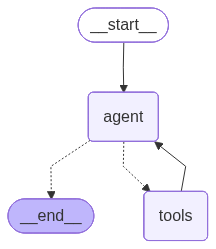

In [18]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
# --- G. EKSEKUSI ---

print("🤖 LegalTech Agent Ready! (Ketik 'quit' buat keluar)\n")

# Simulasi loop chat
import uuid
thread_id = str(uuid.uuid4()) # Session ID unik
config = {"configurable": {"thread_id": thread_id}}

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit"]:
        break
    
    # Input pesan user ke graph
    inputs = {"messages": [HumanMessage(content=user_input)]}
    
    # Stream hasilnya (biar keliatan step-by-step)
    print("\n--- Processing ---")
    for event in app.stream(inputs, config=config):
        for key, value in event.items():
            if key == "agent":
                print("🧠 Agent Mikir...")
                # print(value['messages'][-1].content) # Uncomment kalo mau liat raw thought
            elif key == "tools":
                print("🛠️ Tool Executed!")
    
    # Ambil hasil akhir
    final_state = app.get_state(config)
    print(f"\n🤖 Agent: {final_state.values['messages'][-1].content}\n")
    print("-" * 50)

🤖 LegalTech Agent Ready! (Ketik 'quit' buat keluar)


--- Processing ---
🧠 Agent Mikir...
   🕵️ [TOOL] Filtering Pasal 2 tentang Hak Cipta
   🕵️ [TOOL] Filtering Pasal 3 tentang Hak Cipta
🛠️ Tool Executed!
🧠 Agent Mikir...

🤖 Agent: Berikut adalah isi dari Pasal 2 dan Pasal 3 Undang-Undang No. 28 Tahun 2014 tentang Hak Cipta:

### Pasal 2
Undang-Undang ini berlaku terhadap:
a. semua Ciptaan dan produk Hak Terkait warga negara, penduduk, dan badan hukum Indonesia;
b. negara Indonesia, bukan penduduk Indonesia, dan bukan badan hukum Indonesia yang untuk pertama kali dilakukan Pengumuman di Indonesia;
c. semua Ciptaan dan/atau produk Hak Terkait dan pengguna Ciptaan dan/atau produk Hak Terkait bukan warga negara Indonesia, bukan penduduk Indonesia, dan bukan badan hukum Indonesia dengan ketentuan:
   1. negaranya mempunyai perjanjian bilateral dengan negara Republik Indonesia mengenai pelindungan Hak Cipta dan Hak Terkait; atau
   2. negaranya dan negara Republik Indonesia merupakan pihak

---

### State

In [ ]:
from typing import TypedDict, List, Annotated, Literal
import operator
from langgraph.graph import StateGraph, END
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel
from typing import List, Optional
from pydantic import BaseModel
import operator
from typing import Annotated

In [ ]:
class AgentState(BaseModel):
    question: str
    rewrite_query: str = ""
    # Pake default_factory buat list biar aman di Pydantic
    documents: Annotated[List[Document], operator.add] = Field(default_factory=list)
    loop_count: int = 0
    missing_ref: Optional[str] = None
    
    # PERBAIKAN: Kasih 'Optional' DAN default value '= None'
    # Biar pas start gak error minta ini diisi.
    answer: Optional[str] = None

### Retrive

In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv(override=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="../database",  # Where to save data locally, remove if not necessary
)

retriever = vector_store.as_retriever()

In [ ]:
from langchain.tools import tool

@tool
def retrieve_blog_posts(state: AgentState):
    """Search and return information about regulation software in indonesia."""

    docs = retriever.invoke(state["rewrite_query"])

    return {"documents": docs}

retriever_tool = retrieve_blog_posts

### Router to RAG or Respond

In [ ]:
from typing import Literal
from pydantic import BaseModel, Field

In [ ]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasouce: Literal["vectorstore", "general_chat"] = Field(
        description="Given a user question, choose to route it to 'vectorstore' (for legal/law questions) or 'general_chat' (for greetings, summary, etc)."
    )

llm_router = init_chat_model("gpt-4o-mini", temperature=0)

structured_llm_router = llm_router.with_structured_output(RouteQuery)

def route_question(state: AgentState):
    question = state["question"]
    
    # Tanya ke LLM
    source = structured_llm_router.invoke([("user", question)])
    
    # Cek jawabannya apa
    if source.datasouce == "vectorstore":
        return "break_query" # Ini harus sama persis dengan nama Node lu
    elif source.datasouce == "general_chat":
        return "generate" # Atau node khusus chat biasa kalau ada

### Pecah query

In [ ]:
llm = init_chat_model("gpt-4o-mini", temperature=0)

def break_query(state : AgentState):
    question = state["question"]

    system_break_query = f"""
You are a document search assistant.
A user has a query that requires a document source to answer the question.
Your job is to rewrite the user's question into a list of required document to answer.
The goal is to optimize the document search process.
This output will be provided to the document searcher, not to a human.

regulatory documents available in the database : 

"TENTANG PENYELENGGARA SISTEM ELEKTRONIK LINGKUP PRIVAT"
"TENTANG PENYELENGGARAAN SISTEM DAN TRANSAKSI ELEKTRONIK"
"TENTANG PERDAGANGAN MELALUI SISTEM ELEKTRONIK"
"TENTANG INFORMASI DAN TRANSAKSI ELEKTRONIK"
"PERUBAHAN ATAS UNDANG-UNDANG NOMOR I1 TAHUN 2OO8 TENTANG INFORMASI DAN TRANSAKSI ELEKTRONIK"
"PERUBAHAN KEDUA ATAS UNDANG-UNDANG NOMOR I1 TAHUN 2OO8 TENTANG INFORMASI DAN TRANSAKSI ELEKTRONIK"
"TENTANG PELINDUNGAN DATA PRIBADI"
"TENTANG HAK CIPTA"

user prompt :
{state["question"]}
"""

    ai_msg = llm.invoke(system_break_query)

    return {"rewrite_query": ai_msg, "loop_count": state["loop_count"] + 1}

### Retrive Dokumen

In [ ]:
def retrieve_docs(state: AgentState):
    """Search and return information about software regulation in indonesia."""

    if state["missing_ref"] == "":
        docs = retriever.invoke(state["rewrite_query"])
    else:
        docs = retriever.invoke(state["missing_ref"])

    return {"documents": docs}

### Document Check

In [ ]:
class RouteDocs(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasouce: Literal["yes", "no"] = Field(
        description="Given a user question, choose to route it to 'yes' (if enough information) or 'no' (not enough information)."
    )

structured_llm_docs = llm_router.with_structured_output(RouteDocs)

def route_document(state: AgentState):
    question = f"""
Check whether there are references to other articles that are not yet in this document.

This is the document you're looking for:
{state["rewrite_query"]}

This is the available document:
{state["documents"]}
"""
    
    # Tanya ke LLM
    source = structured_llm_docs.invoke([("user", question)])
    
    # Cek jawabannya apa
    if source.datasouce == "yes":
        return "generate" # Ini harus sama persis dengan nama Node lu
    elif source.datasouce == "no":
        return "makeover_query" # Atau node khusus chat biasa kalau ada

### Dokumen yang kurang

In [ ]:
def missing_docs(state : AgentState):
    question = state["question"]

    system_break_query = f"""
You are a document search assistant.
there are documents sought and documents available.
Your task is to look for lost documents.
This output will be provided to the document retrive, not to a human.

example : 
"PASAL 2 Tentang Hak Cipta"
"Pasal 5 Tentang Perlindungan Data Pribadi"

regulatory documents available in the database : 

"TENTANG PENYELENGGARA SISTEM ELEKTRONIK LINGKUP PRIVAT"
"TENTANG PENYELENGGARAAN SISTEM DAN TRANSAKSI ELEKTRONIK"
"TENTANG PERDAGANGAN MELALUI SISTEM ELEKTRONIK"
"TENTANG INFORMASI DAN TRANSAKSI ELEKTRONIK"
"PERUBAHAN ATAS UNDANG-UNDANG NOMOR I1 TAHUN 2OO8 TENTANG INFORMASI DAN TRANSAKSI ELEKTRONIK"
"PERUBAHAN KEDUA ATAS UNDANG-UNDANG NOMOR I1 TAHUN 2OO8 TENTANG INFORMASI DAN TRANSAKSI ELEKTRONIK"
"TENTANG PELINDUNGAN DATA PRIBADI"
"TENTANG HAK CIPTA"

This is the document you're looking for:
{state["rewrite_query"]}

This is the available document:
{state["documents"]}
"""

    ai_msg = llm.invoke(system_break_query)

    return {"missing_ref": ai_msg, "loop_count": state["loop_count"] + 1}

### Generate

In [ ]:
def generate_node(state: AgentState):

    message = f"""
You are a legal consultant assistant for software development in Indonesia.
Your job is to answer user questions based on the available documents.

user question:
{state["question"]}

avaible docs: 
{state["documents"]}
"""
    ai_answer = llm.invoke(message)

    return {"answer": ai_answer}

### Workflow

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node(break_query)
workflow.add_node(retrieve_docs)
workflow.add_node(missing_docs)
workflow.add_node(generate_node)

# Decide whether to retrieve
workflow.add_conditional_edges(
    START,
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    route_question,
    {
        # Translate the condition outputs to nodes in our graph
        "break_query": "break_query",
        "generate": "generate_node",
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve_docs",
    # Assess agent decision
    route_document,
    {
        "generate": "generate_node",
        "makeover_query": "missing_docs"
    }
)
workflow.add_edge("break_query", "retrieve_docs")
workflow.add_edge("missing_docs", "retrieve_docs")
workflow.add_edge("generate_node", END)

# Compile
graph = workflow.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## TES

In [ ]:
result = graph.invoke({
    "question": "Siapa saja yang wajib mendaftar sebagai Penyelenggara Sistem Elektronik (PSE) Lingkup Privat?"
})


print(result["rewrite_query"])
print(result["loop_count"])
print(result["answer"])

---